In [1]:
###################################################
# Author: Sandro da Silva Camargo and Fernando Cardoso
# Course: Biostatistics
# Federal University of Pampa - Bage - PPGCAP
#
# Teste Volumosos e Fontes de Proteínas
###################################################
!pip install pingouin
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats
import pingouin as pg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 4.6 MB/s eta 0:00:00


In [2]:
# ----------------------------------------------------------
# LEITURA DOS DADOS
# ----------------------------------------------------------
dados = pd.read_csv("https://raw.githubusercontent.com/Sandrocamargo/biostatistics/refs/heads/master/datasets/fatorial-dbc-dados.txt", sep="\t", header=0)

# Converte para fatores (categorias)
for col in ["TR", "VAR", "PROT", "BL"]:
    dados[col] = dados[col].astype("category")

# Renomeia para manter compatibilidade com R
dados.rename(columns={"PROT": "PR"}, inplace=True)

dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   TR      24 non-null     category
 1   VAR     24 non-null     category
 2   PR      24 non-null     category
 3   BL      24 non-null     category
 4   PG      24 non-null     int64   
dtypes: category(4), int64(1)
memory usage: 1.1 KB


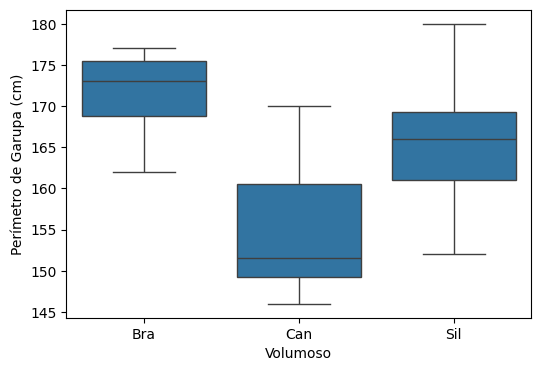

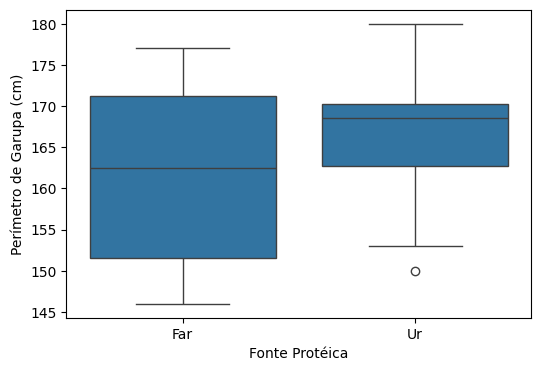

In [4]:
# ----------------------------------------------------------
# GRÁFICOS INICIAIS (OUTLIERS)
# ----------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.boxplot(x="VAR", y="PG", data=dados)
plt.xlabel("Volumoso"); plt.ylabel("Perímetro de Garupa (cm)")
plt.savefig("fat1-boxplot-volumoso.pdf")

plt.figure(figsize=(6, 4))
sns.boxplot(x="PR", y="PG", data=dados)
plt.xlabel("Fonte Protéica"); plt.ylabel("Perímetro de Garupa (cm)")
plt.savefig("fat1-boxplot-fonte.pdf")

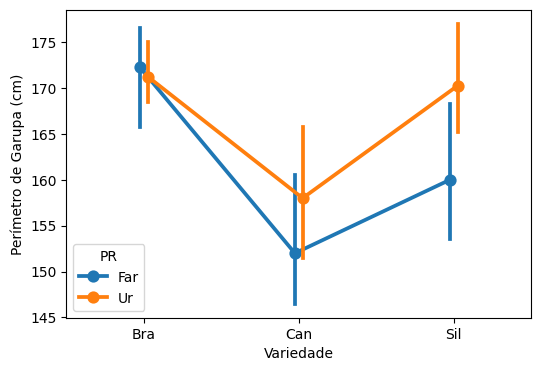

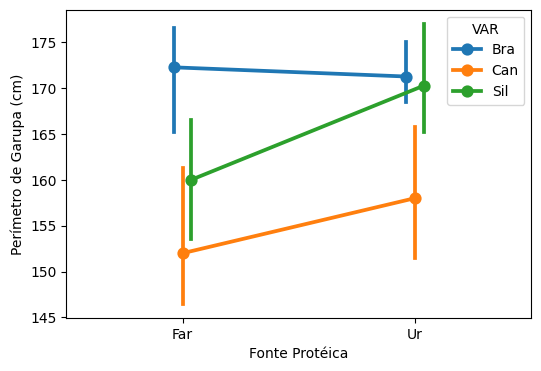

In [5]:
# ----------------------------------------------------------
# GRÁFICOS DE INTERAÇÃO
# ----------------------------------------------------------
plt.figure(figsize=(6, 4))
sns.pointplot(x="VAR", y="PG", hue="PR", data=dados, dodge=True, markers="o")
plt.xlabel("Variedade"); plt.ylabel("Perímetro de Garupa (cm)")
plt.savefig("fat1-iter-variedade.pdf")

plt.figure(figsize=(6, 4))
sns.pointplot(x="PR", y="PG", hue="VAR", data=dados, dodge=True, markers="o")
plt.xlabel("Fonte Protéica"); plt.ylabel("Perímetro de Garupa (cm)")
plt.savefig("fat1-iter-fonte.pdf")

In [6]:
# ----------------------------------------------------------
# ANÁLISE DE VARIÂNCIA
# ----------------------------------------------------------
modelo = ols("PG ~ C(VAR) + C(PR) + C(VAR):C(PR) + C(BL)", data=dados).fit()
anova = anova_lm(modelo, typ=2)
print("\n=== ANOVA ===")
print(anova)


=== ANOVA ===
                   sum_sq    df          F    PR(>F)
C(VAR)        1138.583333   2.0  17.446582  0.000122
C(PR)          155.041667   1.0   4.751426  0.045620
C(BL)          508.791667   3.0   5.197497  0.011638
C(VAR):C(PR)   129.083333   2.0   1.977952  0.172823
Residual       489.458333  15.0        NaN       NaN



Shapiro-Wilk Test:
ShapiroResult(statistic=np.float64(0.9408088275521843), pvalue=np.float64(0.17003548256970064))

Levene Test:
LeveneResult(statistic=np.float64(0.41090755593076356), pvalue=np.float64(0.83495621575186))

Durbin-Watson: 1.691


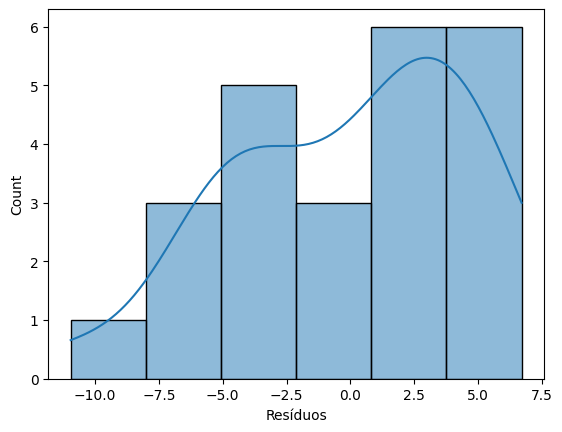

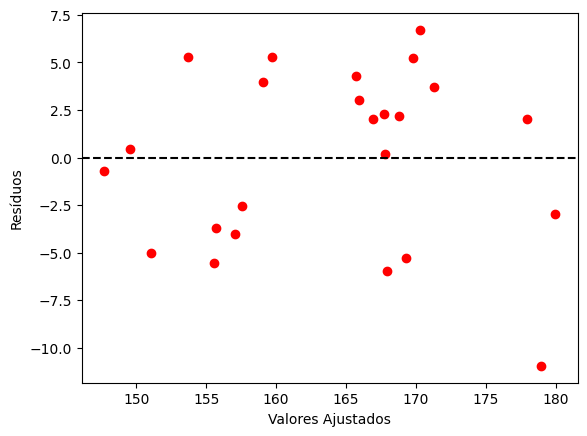

In [8]:
# ----------------------------------------------------------
# DIAGNÓSTICO DE PRESSUPOSIÇÕES
# ----------------------------------------------------------
residuo = modelo.resid
ajustado = modelo.fittedvalues

# Normalidade dos resíduos
print("\nShapiro-Wilk Test:")
print(stats.shapiro(residuo))

# Homocedasticidade (teste de Levene)
print("\nLevene Test:")
print(stats.levene(*[residuo[dados["TR"] == tr] for tr in dados["TR"].unique()]))

# Independência (Durbin-Watson)
dw = sm.stats.durbin_watson(residuo)
print(f"\nDurbin-Watson: {dw:.3f}")

# Gráficos diagnósticos
plt.figure()
sns.histplot(residuo, kde=True)
plt.xlabel("Resíduos")
plt.savefig("fat1-hist-residuos.pdf")

plt.figure()
plt.scatter(ajustado, residuo, color='red')
plt.xlabel("Valores Ajustados")
plt.ylabel("Resíduos")
plt.axhline(0, color='black', linestyle='--')
plt.savefig("fat1-residuos-ajustados.pdf")


Tukey HSD para Variedade:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
   Bra    Can   -16.75 0.0009 -26.5984 -6.9016   True
   Bra    Sil   -6.625 0.2303 -16.4734  3.2234  False
   Can    Sil   10.125 0.0432   0.2766 19.9734   True
-----------------------------------------------------

Tukey HSD para Fonte Protéica:
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   Far     Ur   5.0833 0.2328 -3.5091 13.6758  False
----------------------------------------------------


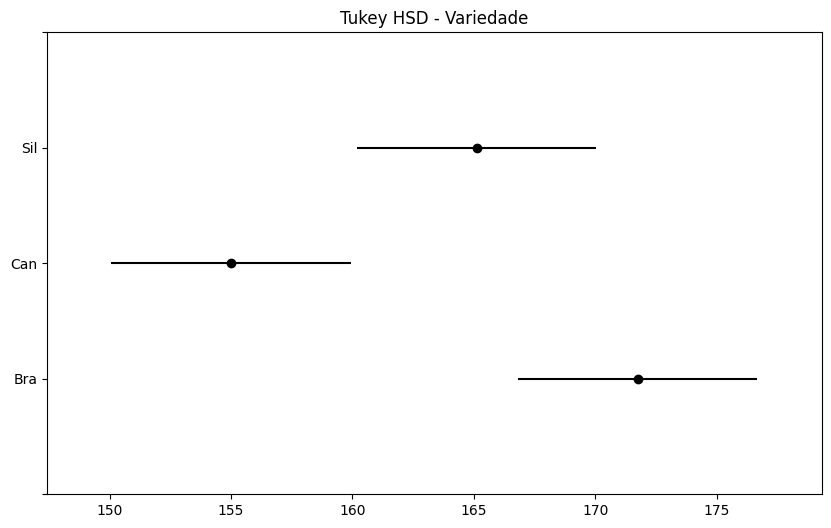

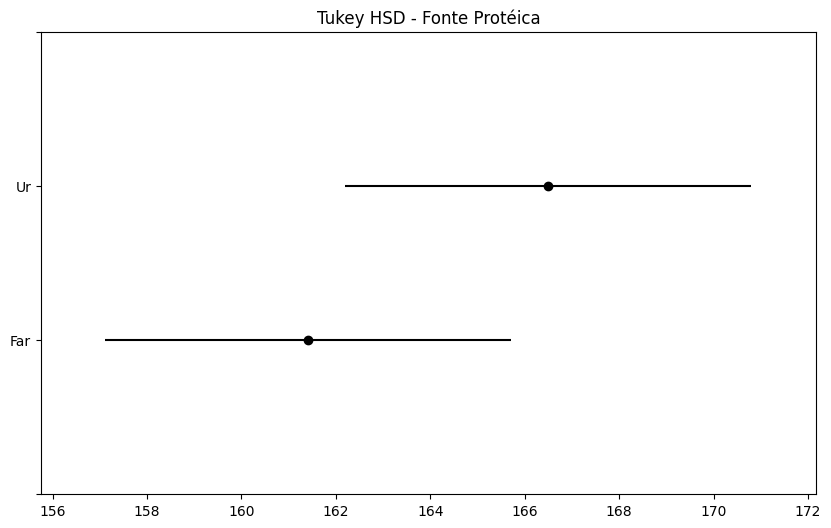

In [9]:
# ----------------------------------------------------------
# TESTES DE TUKEY (comparações múltiplas)
# ----------------------------------------------------------
print("\nTukey HSD para Variedade:")
tukey_var = pairwise_tukeyhsd(dados["PG"], dados["VAR"])
print(tukey_var)

print("\nTukey HSD para Fonte Protéica:")
tukey_pr = pairwise_tukeyhsd(dados["PG"], dados["PR"])
print(tukey_pr)

# Gráficos de Tukey
tukey_var.plot_simultaneous()
plt.title("Tukey HSD - Variedade")
plt.savefig("fat1-tukey-variedade.pdf")

tukey_pr.plot_simultaneous()
plt.title("Tukey HSD - Fonte Protéica")
plt.savefig("fat1-tukey-fonte.pdf")

In [10]:
# ----------------------------------------------------------
# MÉDIAS AGRUPADAS (equivalente ao emmeans + cld)
# ----------------------------------------------------------
print("\nMédias e Grupos de Variedade:")
pg.pairwise_tukey(dv="PG", between="VAR", data=dados)

print("\nMédias e Grupos de Fonte Protéica:")
pg.pairwise_tukey(dv="PG", between="PR", data=dados)


Médias e Grupos de Variedade:

Médias e Grupos de Fonte Protéica:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Far,Ur,161.416667,166.5,-5.083333,4.143191,-1.226912,0.232824,-0.483613


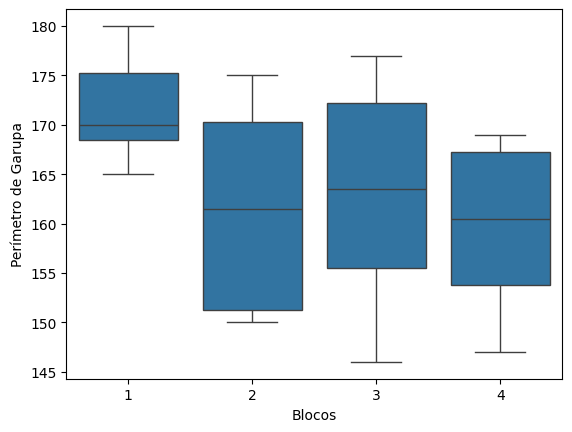

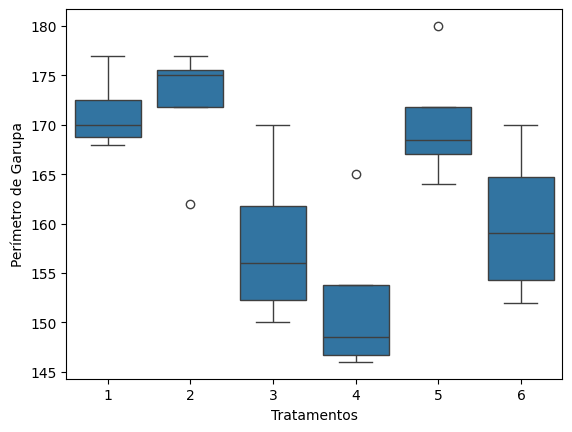

In [13]:
# ----------------------------------------------------------
# BOXPLOTS FINAIS
# ----------------------------------------------------------
sns.boxplot(x="BL", y="PG", data=dados)
plt.xlabel("Blocos"); plt.ylabel("Perímetro de Garupa")
plt.savefig("fat1-boxplot-bloco.pdf")

plt.figure()
sns.boxplot(x="TR", y="PG", data=dados)
plt.xlabel("Tratamentos"); plt.ylabel("Perímetro de Garupa")
plt.savefig("fat1-boxplot-tratamento.pdf")
